In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-11-08 22:04.


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [3]:
## ----- Setup working dir
sp_name = "1_IL2RAKO"
analysis_name = ["0", "all"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

1_IL2RAKO


In [4]:
###----- old - new cluster names
order_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [14]:
all_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/0-all_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata = scv.read(all_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/1-ACTonly_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act = scv.read(act_h5ad)

act_wt_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/2-actWT_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act_wt = scv.read(act_wt_h5ad)

act_ko_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/2_scVelo/2-actKO_Dyn_scVelo_out/1_IL2RAKO_scVelo.h5ad'
adata_act_ko = scv.read(act_ko_h5ad)

In [15]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [7]:
### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkerSelect/master/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2OYMCLEV2LQHJGP7NJS7WG2IS')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

### Gene signature genes
gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
gs_plot_use_df = pd.read_csv(gs_plot_use_file)
gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
gs_df = pd.read_csv(gs_file)
gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

genes_use = [i for i in genes_use if i in all_genes]

In [8]:
out_dir = wk_dir + '/likelihood_genes_drivers'
Path(out_dir).mkdir(parents=True, exist_ok=True)

## All

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_paga', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_velocity_embedding_stream_Dyn.png


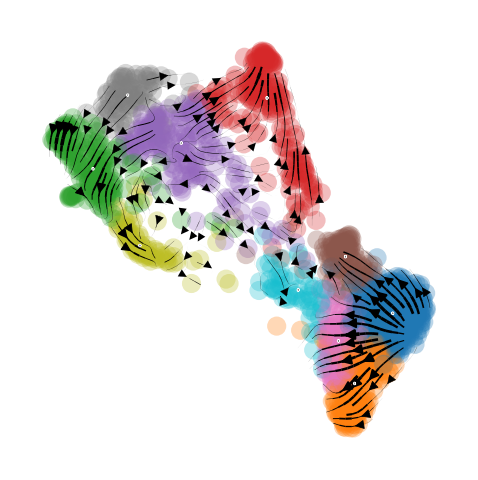

In [9]:
### Velocity embedding stream with PAGA FA2 projection
save_name = 'velocity_embedding_stream_Dyn'

### Plot
rcParams['figure.figsize'] = 4,4
scv.pl.velocity_embedding_stream(adata, basis='paga', legend_fontsize=0, frameon=False, title="",
                                 xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), save=save_name + ".png")

## Extract likelihood genes for all activated cells ARM v.s. CL13

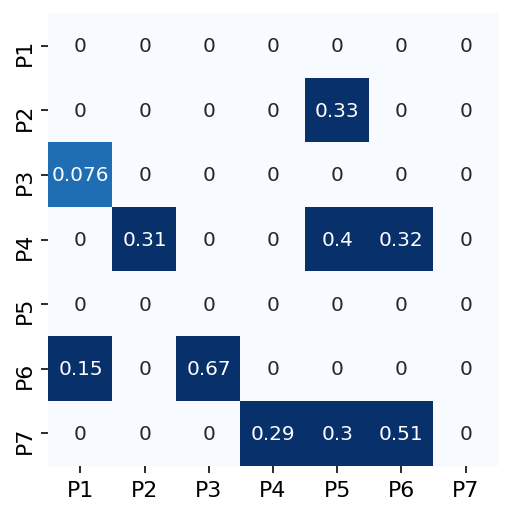

In [20]:
###---- WT transition probability
save_name = 'act_wt_transition'

### Plot
rcParams['figure.figsize'] = 4,4

df = scv.get_df(adata_act_wt, 'paga/transitions_confidence', precision=2).T
df.columns = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.columns ]
df.index = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.index ]
use_louvain_order = [x for x in louvain_new_ordered[3:] if x in df.index.tolist()]
df = df[use_louvain_order]
df = df.loc[use_louvain_order]
sns.heatmap(df, annot=True, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
plt.savefig(save_name + ".png")
plt.show()
plt.close()

saving figure to file ./figures/scvelo_wt_transition_node.png


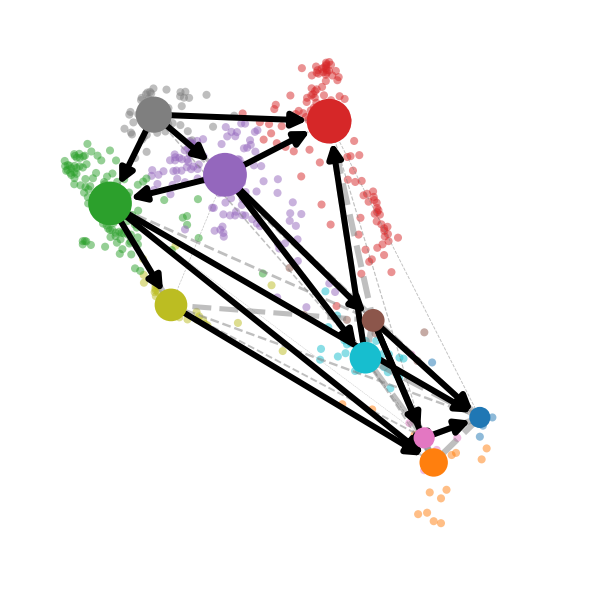

In [22]:
###---- WT transition probability node plot
save_name = 'wt_transition_node'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.paga(adata_act_wt, basis='paga', min_edge_width=3, node_size_scale=1.5, legend_loc=None, title="", 
            xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax),save=save_name+".png")

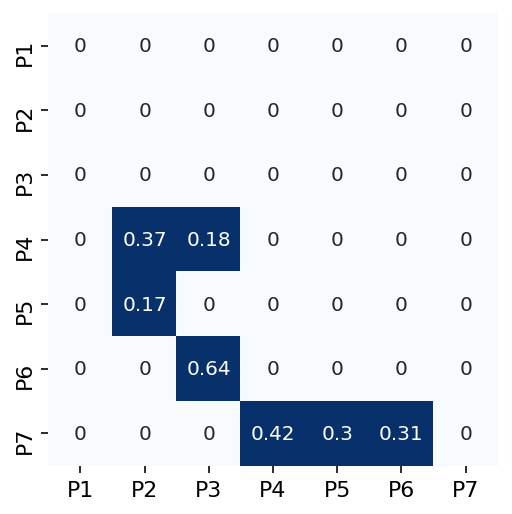

In [21]:
###---- WT transition probability
save_name = 'act_ko_transition'

### Plot
rcParams['figure.figsize'] = 4,4

df = scv.get_df(adata_act_ko, 'paga/transitions_confidence', precision=2).T
df.columns = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.columns ]
df.index = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.index ]
use_louvain_order = [x for x in louvain_new_ordered[3:] if x in df.index.tolist()]
df = df[use_louvain_order]
df = df.loc[use_louvain_order]
sns.heatmap(df, annot=True, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
plt.savefig(save_name + ".png")
plt.show()
plt.close()

saving figure to file ./figures/scvelo_ko_transition_node.png


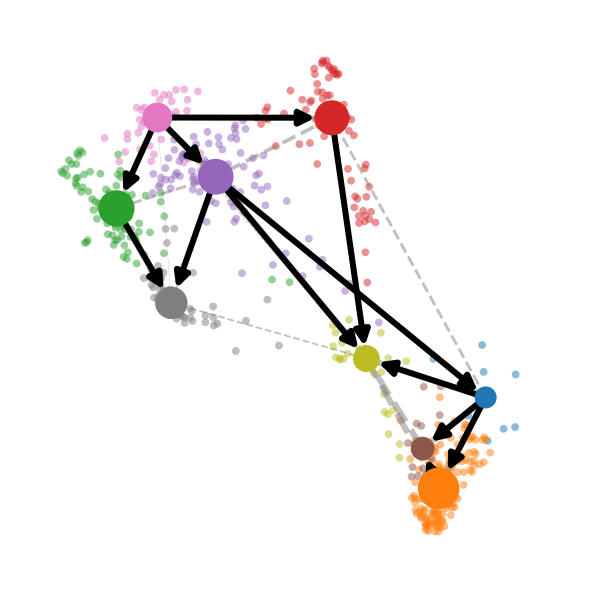

In [23]:
###---- WT transition probability node plot
save_name = 'ko_transition_node'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.paga(adata_act_ko, basis='paga', min_edge_width=3, node_size_scale=1.5, legend_loc=None, title="", 
            xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax),save=save_name+".png")

## Key driver genes

In [33]:
trajectory_streams_dir = wk_dir + '/trajectory_streams'
Path(trajectory_streams_dir).mkdir(parents=True, exist_ok=True)
os.chdir(trajectory_streams_dir)

In [34]:
drivers_df = pd.read_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/1_IL2RAKO/0_all/scVelo/likelihood_genes_drivers/act_WT-KO_likelihood_genes.csv')
gene_list = set(drivers_df['WT_ranked'].tolist()[:10] + drivers_df['KO_ranked'].tolist()[:10])

saving figure to file ./figures/scvelo_Act_WT_velocity-stream.png


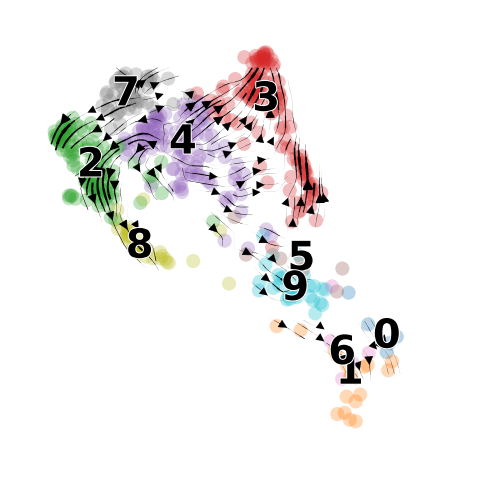

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Il6ra.png


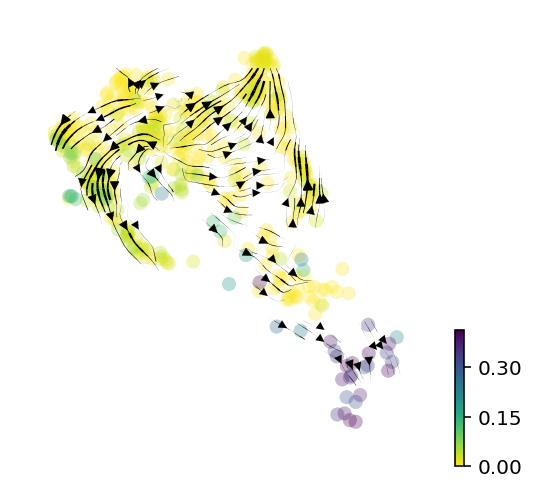

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Rora.png


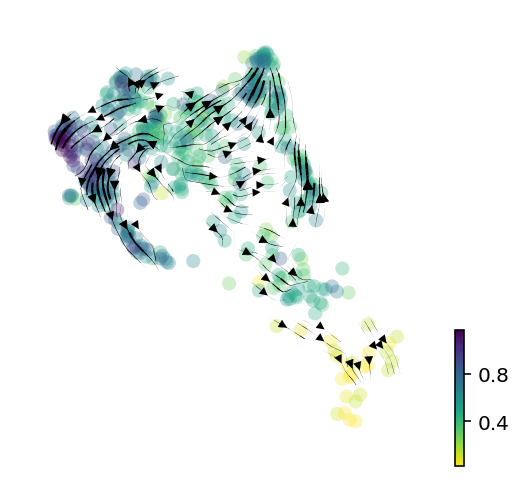

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Klra3.png


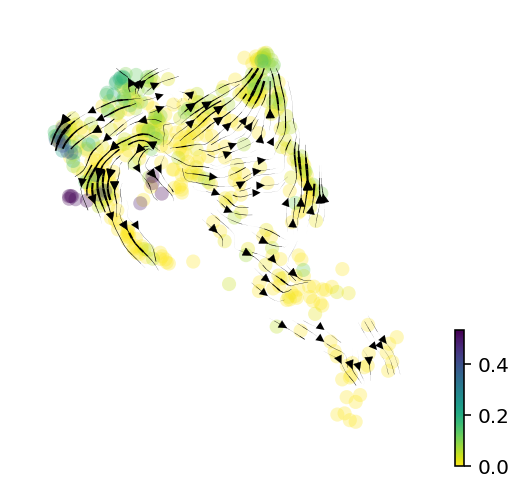

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Lef1.png


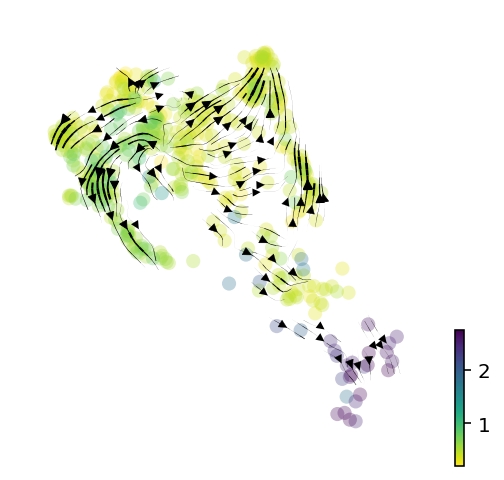

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Il18rap.png


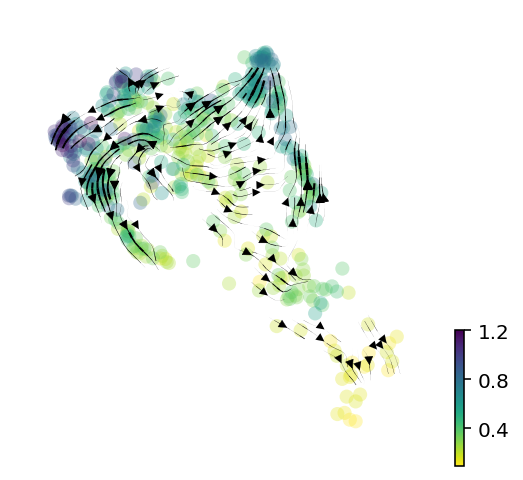

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Mcm7.png


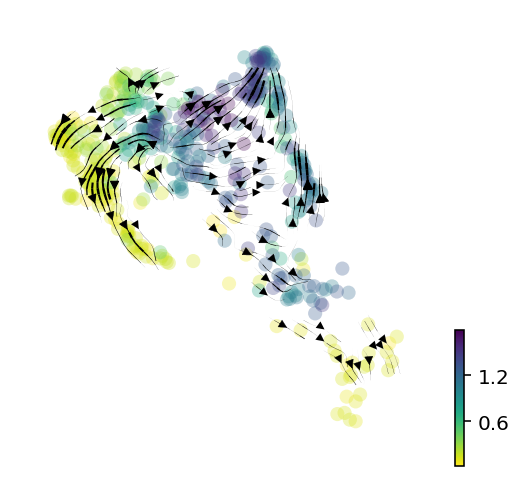

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Ncr1.png


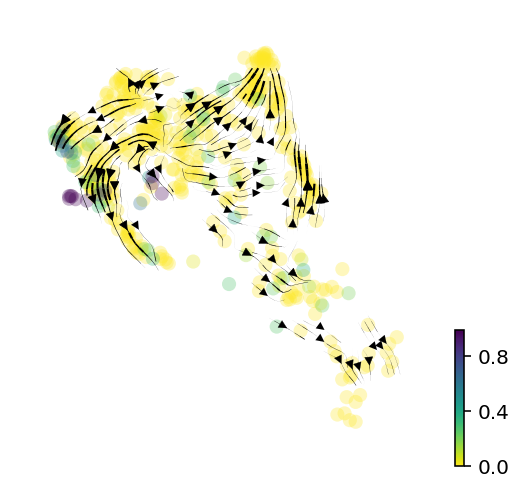

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Itga4.png


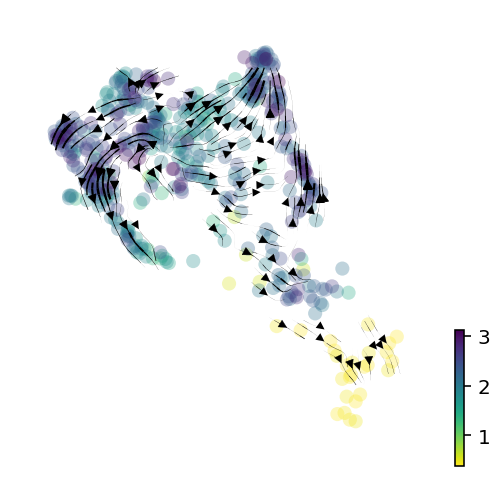

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Tbx21.png


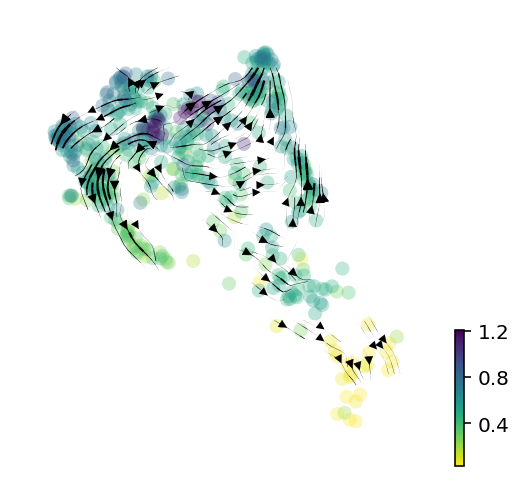

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Scml4.png


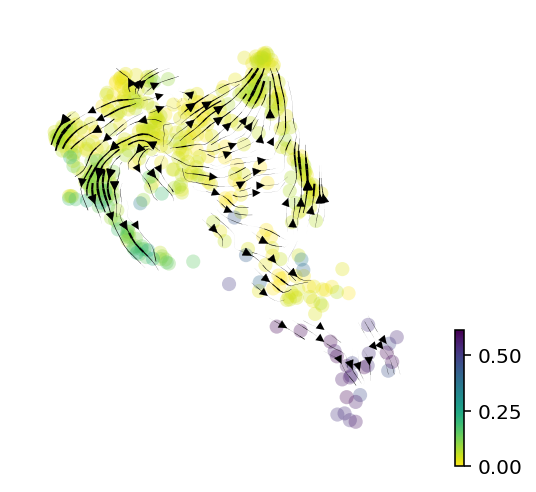

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Hells.png


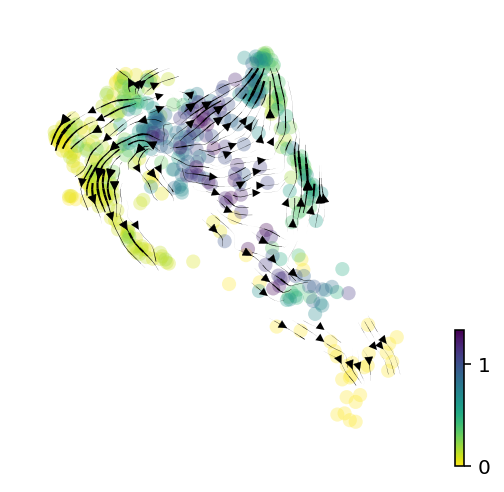

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Itgal.png


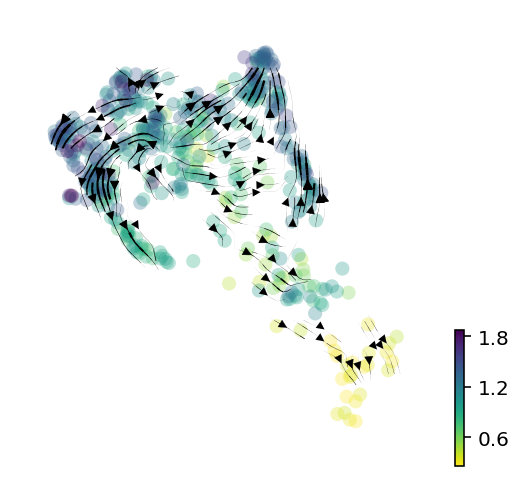

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Sell.png


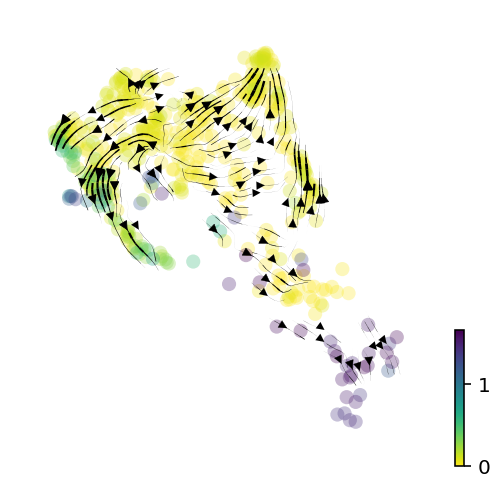

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Ssbp2.png


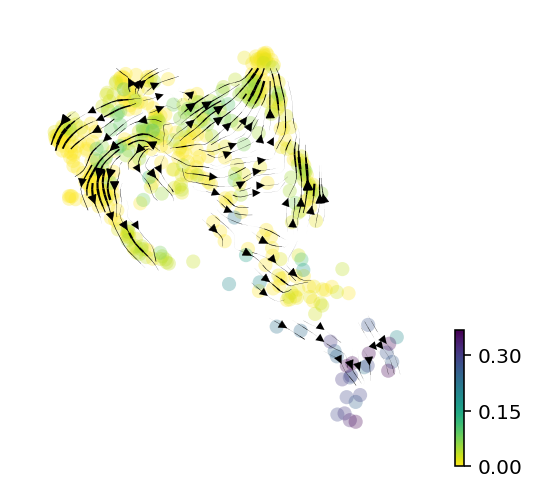

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Tnfsf8.png


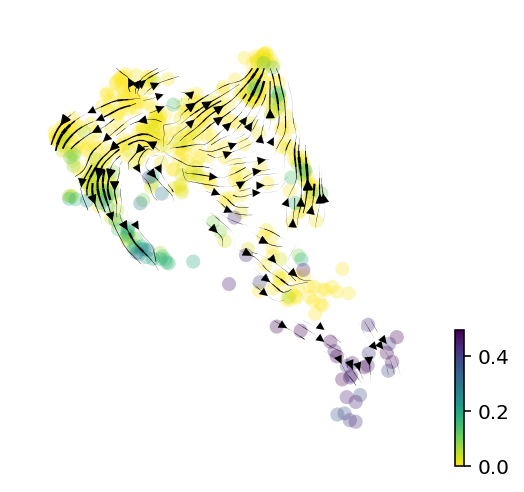

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Ezh2.png


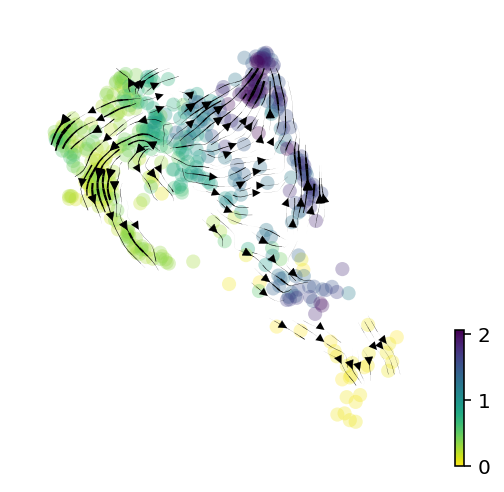

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Nap1l1.png


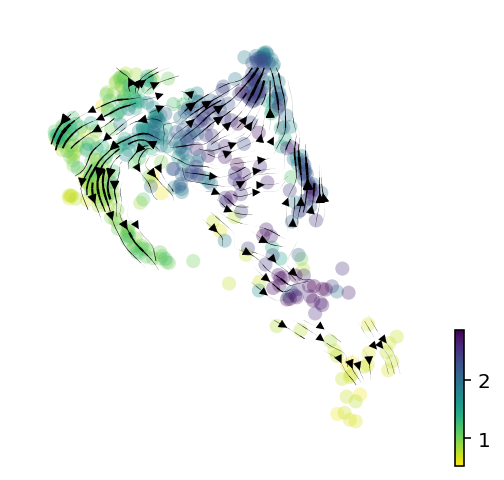

saving figure to file ./figures/scvelo_Act_WT_velocity-stream_Mcm4.png


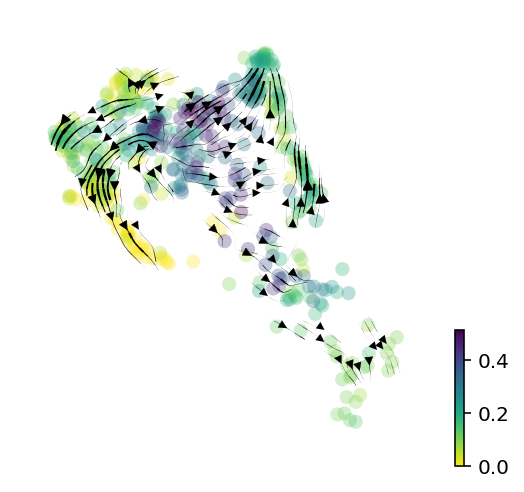

saving figure to file ./figures/scvelo_Act_KO_velocity-stream.png


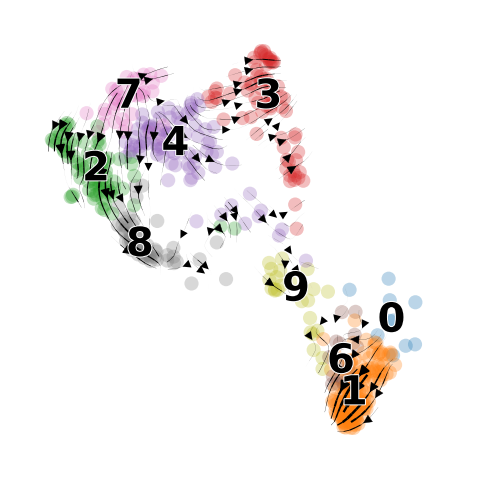

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Il6ra.png


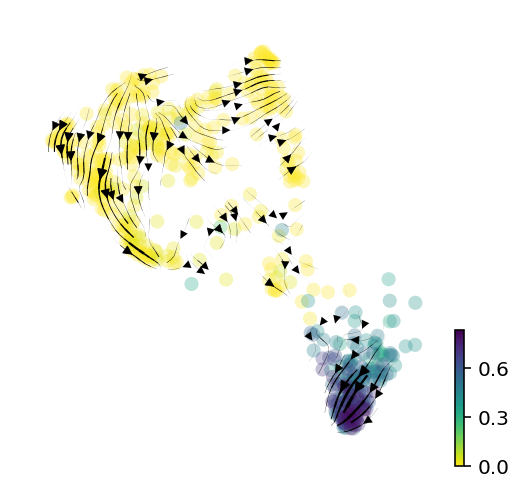

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Rora.png


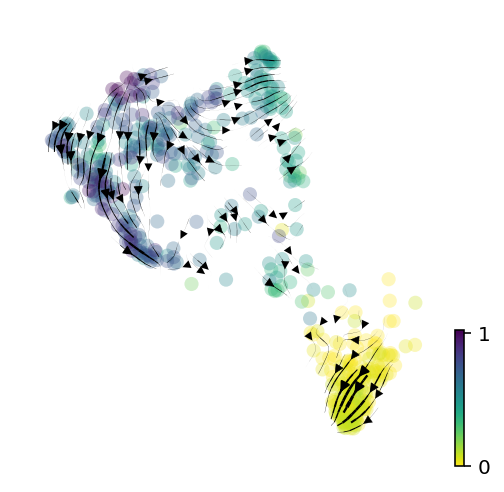

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Klra3.png


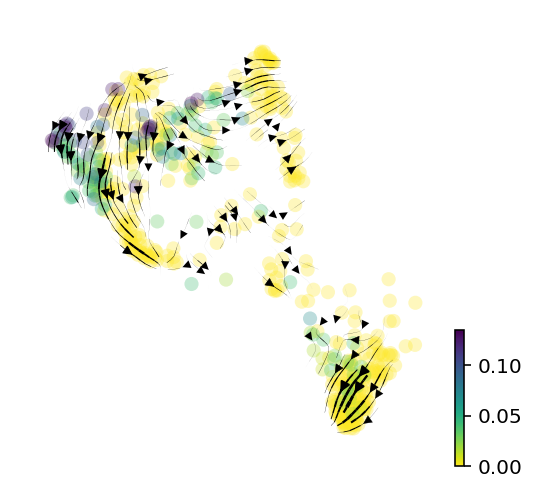

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Lef1.png


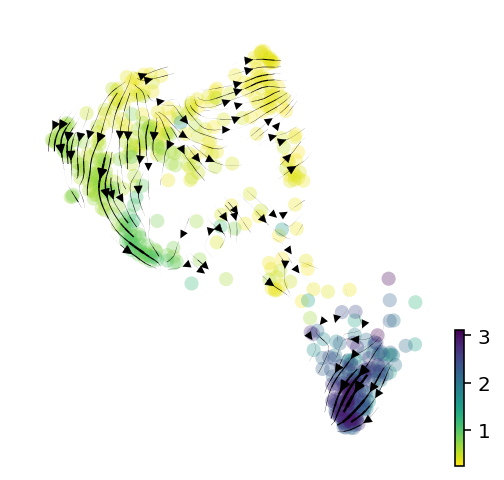

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Il18rap.png


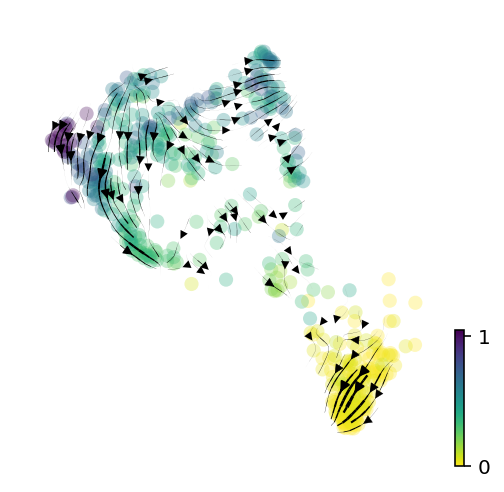

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Mcm7.png


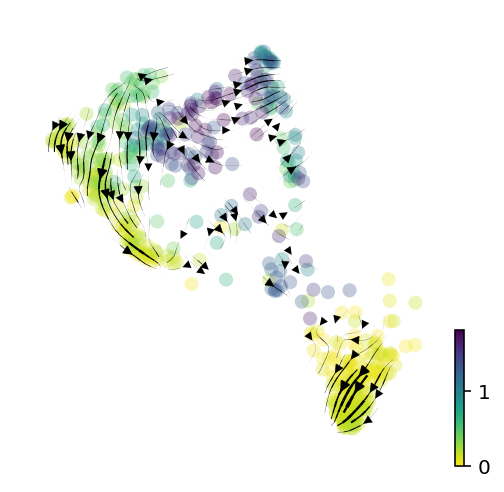

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Ncr1.png


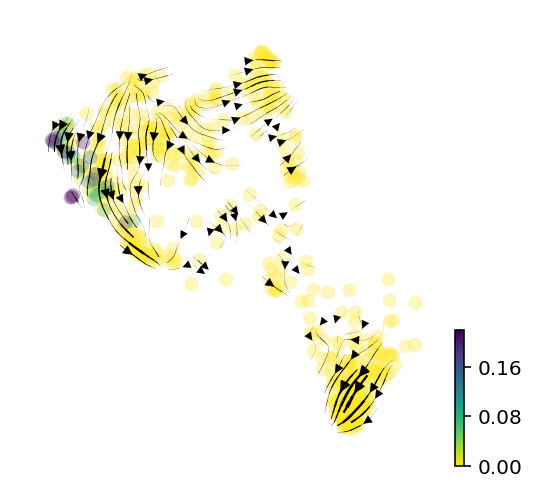

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Itga4.png


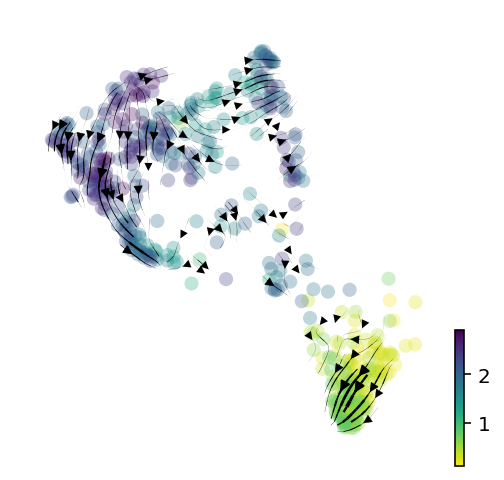

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Tbx21.png


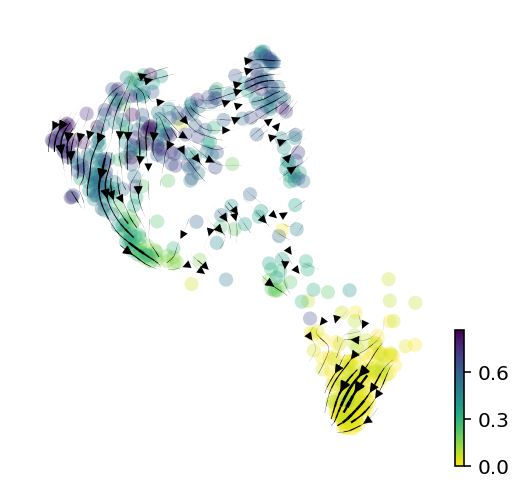

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Scml4.png


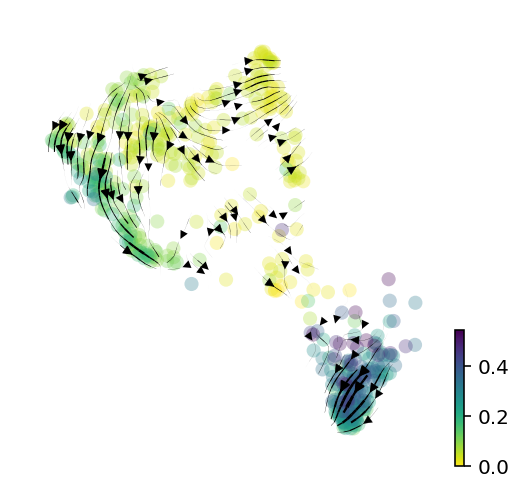

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Hells.png


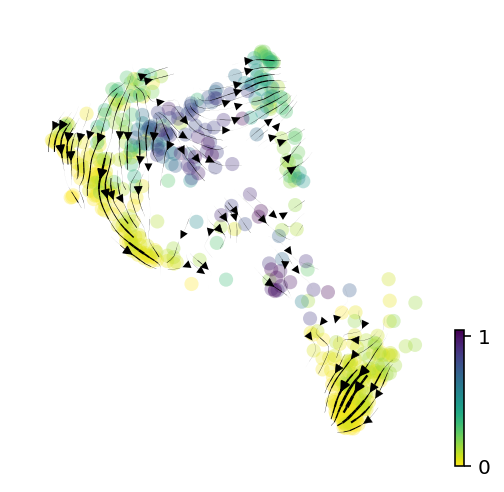

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Itgal.png


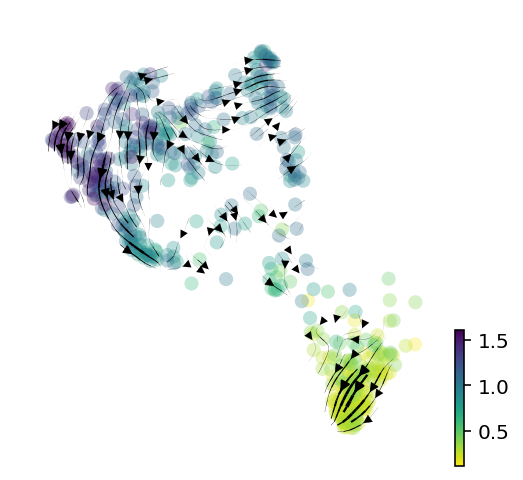

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Sell.png


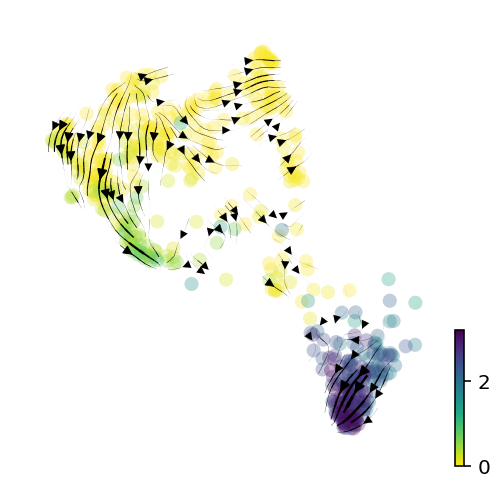

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Ssbp2.png


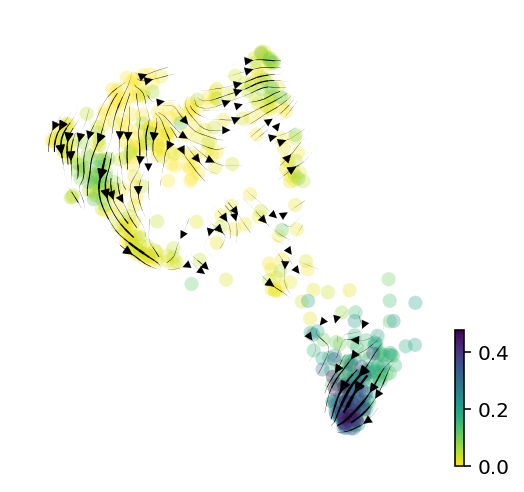

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Tnfsf8.png


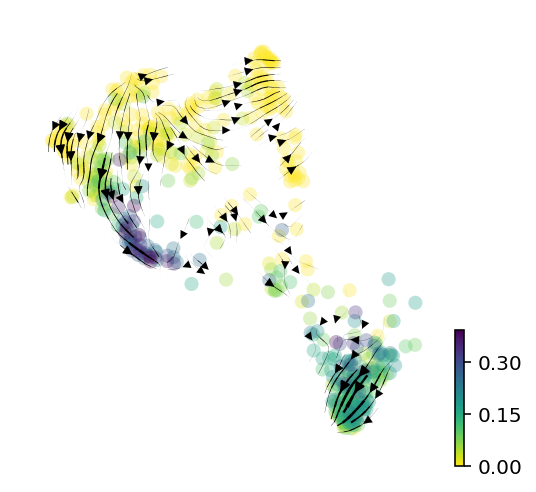

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Ezh2.png


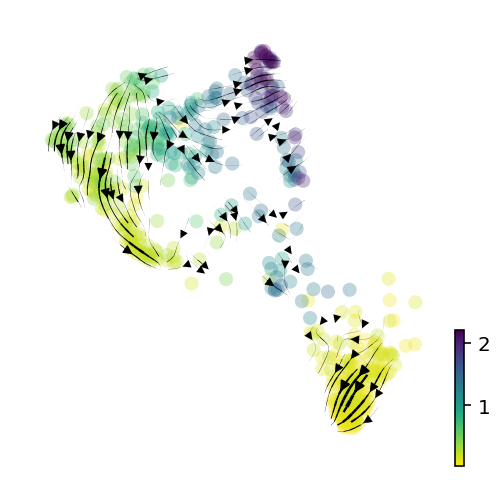

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Nap1l1.png


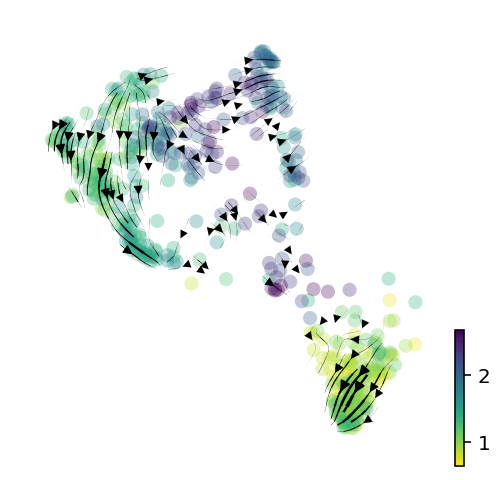

saving figure to file ./figures/scvelo_Act_KO_velocity-stream_Mcm4.png


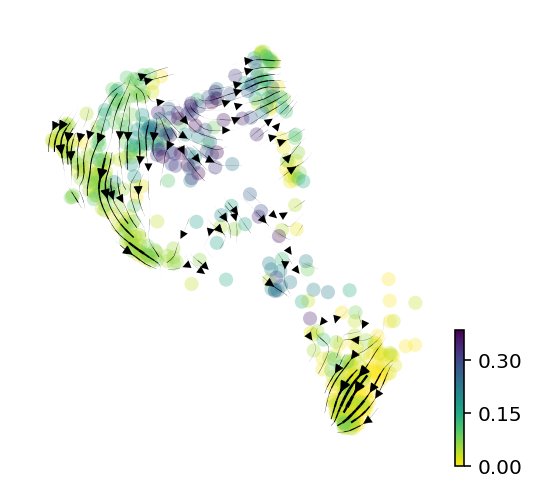

In [47]:
type_dict = {"WT":adata_act_wt, "KO":adata_act_ko}

outname_base = "Act"

rcParams['figure.figsize'] = 4,4
for t, adata_t in type_dict.items():
    # Outname for plots
    out_name = "%s_%s_velocity-stream"%(outname_base, t)
    # louvain colored plot
    scv.pl.velocity_embedding_stream(adata_t, basis='paga', legend_fontsize=20, title="",
                                xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), size=200, save = "%s.png"%out_name)
    # Gene plots
    for gene in gene_list:
        scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Ms",
                                 xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), size=200, color_map='viridis_r',
                                 save = "%s_%s.png"%(out_name, gene))